## Change variables in this cell 
    - specify the day you want to analyze.
    - specifiy trials to be analyzed: correct, incorrect or all

In [1]:
outcome2ana = 'corr' # '', corr', 'incorr' : analyze all, correct or incorrect trials

mousename = 'fni17'
imagingFolder = '151102'
mdfFileNumber = [1,2] 

## Import Libraries and Modules

In [2]:
import scipy.io as scio
import scipy as sci
import numpy as np
import numpy.random as rng

from crossValidateModel import crossValidateModel
from linearSVM import linearSVM
from compiler.ast import flatten
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)
from IPython.display import display
import sklearn.svm as svm
import os

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.


In [3]:
import sys
print sys.path
sys.path.append('/home/farznaj/Documents/trial_history/imaging') # Gamal's dir needs to be added using "if" that takes the value of pwd
# print sys.path

['', '/home/farznaj/anaconda2/lib/python27.zip', '/home/farznaj/anaconda2/lib/python2.7', '/home/farznaj/anaconda2/lib/python2.7/plat-linux2', '/home/farznaj/anaconda2/lib/python2.7/lib-tk', '/home/farznaj/anaconda2/lib/python2.7/lib-old', '/home/farznaj/anaconda2/lib/python2.7/lib-dynload', '/home/farznaj/anaconda2/lib/python2.7/site-packages', '/home/farznaj/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/home/farznaj/anaconda2/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/home/farznaj/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/farznaj/.ipython']


In [4]:
# Set mat file names

pnev2load = [] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.
signalCh = [2] # since gcamp is channel 2, should be always 2.

from setImagingAnalysisNamesP import *

imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, signalCh=signalCh, pnev2load=pnev2load)

postName = os.path.join(os.path.dirname(pnevFileName), 'post_'+os.path.basename(pnevFileName))

print(imfilename)
print(pnevFileName)
print(postName)


/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/151102_001-002.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/151102_001-002_ch2-PnevPanResults-160830-200511.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/post_151102_001-002_ch2-PnevPanResults-160830-200511.mat


## Load matlab variables

In [5]:
frameLength = 1000/30.9; # sec.

# Load stimulus-aligned traces, frames, frame of event of interest, and epoch over which we will average the responses to do SVM analysis
Data = scio.loadmat(postName, variable_names=['stimAl'],squeeze_me=True,struct_as_record=False)
eventI = Data['stimAl'].eventI - 1 # remember difference indexing in matlab and python!
traces_al_stim = Data['stimAl'].traces.astype('float') # traces_al_stim
time_aligned_stim = Data['stimAl'].time.astype('float')
ep = Data['stimAl'].ep - 1 # 600ms:stimEnd
print 'training epoch is {}'.format(np.round((ep-eventI)*frameLength))
print(np.shape(traces_al_stim))
# print(np.shape(time_aligned_stim))
# print(ep)


# Load 1stSideTry-aligned traces, frames, frame of event of interest
# use firstSideTryAl_COM to look at changes-of-mind (mouse made a side lick without committing it)
Data = scio.loadmat(postName, variable_names=['firstSideTryAl'],squeeze_me=True,struct_as_record=False)
traces_al_1stSide = Data['firstSideTryAl'].traces.astype('float')
time_aligned_1stSide = Data['firstSideTryAl'].time.astype('float')
print(np.shape(traces_al_1stSide))
# print(np.shape(time_aligned_1stSide))


# Load goTone-aligned traces, frames, frame of event of interest
# use goToneAl_noStimAft to make sure there was no stim after go tone.
Data = scio.loadmat(postName, variable_names=['goToneAl'],squeeze_me=True,struct_as_record=False)
traces_al_go = Data['goToneAl'].traces.astype('float')
time_aligned_go = Data['goToneAl'].time.astype('float')
print(np.shape(traces_al_go))


# Load reward-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['rewardAl'],squeeze_me=True,struct_as_record=False)
traces_al_rew = Data['rewardAl'].traces.astype('float')
time_aligned_rew = Data['rewardAl'].time.astype('float')
print(np.shape(traces_al_rew))



# Load commitIncorrect-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['commitIncorrAl'],squeeze_me=True,struct_as_record=False)
traces_al_incorrResp = Data['commitIncorrAl'].traces.astype('float')
time_aligned_incorrResp = Data['commitIncorrAl'].time.astype('float')
print(np.shape(traces_al_incorrResp))



# Load outcomes and allResp_HR_LR
Data = scio.loadmat(postName, variable_names=['outcomes', 'allResp_HR_LR'])

outcomes = (Data.pop('outcomes').astype('float'))[0,:]
allResp_HR_LR = (Data.pop('allResp_HR_LR').astype('float'))[0,:]
# print(outcomes.shape)
# print(allResp_HR_LR.shape)

# Set to nan those trials in outcomes and allRes that are nan in traces_al_stim
I = (np.argwhere((~np.isnan(traces_al_stim).sum(axis=0)).sum(axis=1)))[0][0] # first non-nan neuron
allTrs2rmv = np.argwhere(sum(np.isnan(traces_al_stim[:,I,:])))
print(np.shape(allTrs2rmv))

outcomes[allTrs2rmv] = np.nan
allResp_HR_LR[allTrs2rmv] = np.nan

training epoch is [ 518.  550.  583.  615.  647.  680.  712.]
(76, 297, 178)
(78, 297, 178)
(69, 297, 178)
(79, 297, 178)
(148, 297, 178)
(20, 1)


## Set traces (frames x neurons x trials), X (trials x neurons) and Y (trials x 1)
    Traces are aligned on stimulus and choice
    X matrix (size trials x neurons) that contains neural responses at different trials.
    Y choice of high rate (modeled as 1) and low rate (modeled as 0)

In [6]:
# Set Y: the response vector

# if trialHistAnalysis
#     popClassifier_trialHistory
# else
choiceVec0 = np.transpose(allResp_HR_LR);  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.

if outcome2ana == 'corr':
    choiceVec0[outcomes!=1] = np.nan; # analyze only correct trials.
elif outcome2ana == 'incorr':
    choiceVec0[outcomes!=0] = np.nan; # analyze only incorrect trials.

# Y = choiceVec0
print(choiceVec0.shape)
print '#correct choices= %d; #incorrect choices= %d' %(sum(outcomes==1), sum(outcomes==0))

(178,)
#correct choices= 119; #incorrect choices= 37


In [7]:
# Set X: the predictor matrix (trials x neurons) that shows average of spikes for a particular epoch for each trial and neuron.

spikeAveEp0 = np.transpose(np.nanmean(traces_al_stim[ep,:,:], axis=0)) # trials x neurons
# spikeAveEp0 = np.matrix(np.transpose(np.nanmean(traces_al_stim[ep,:,:], axis=0))) # trials x neurons

# X = spikeAveEp0;
print(spikeAveEp0.shape)

(178, 297)


/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


# non-active neurons = 2
 The data has 119 trials recorded from 295 neurons
 The data has 76 frames recorded from 295 neurons at 119 trials
(69, 295, 119)


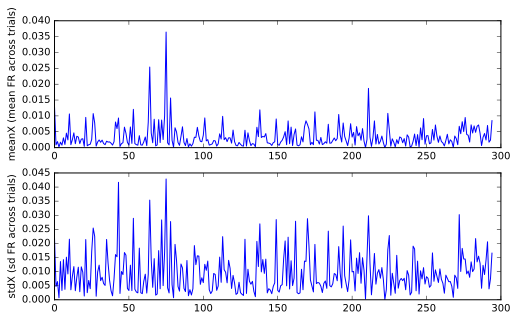

In [8]:
# Set final traces by excluding nan trials and non-active neurons

'''
#dirName = 'SVM_151102_001-002_ch2-PnevPanResults-160624-113108';
dirName = 'SVM_151029_003_ch2-PnevPanResults-160426-191859';
#dirName = '/home/farznaj/Shares/Churchland/data/fni17/imaging/151022/XY_fni17_151022 XY_lassoSVM.mat';
Data = scio.loadmat(dirName, variable_names=['X', 'Y', 'time_aligned_stim', 'non_filtered', 'traces_al_1stSideTry', 'time_aligned_stim_1stSideTry']);
X = Data.pop('X').astype('float')
Y = np.squeeze(Data.pop('Y')).astype('int')
time_aligned_stim = np.squeeze(Data.pop('time_aligned_stim')).astype('float')
Xt = Data.pop('non_filtered').astype('float')
Xt_choiceAl = Data.pop('traces_al_1stSideTry').astype('float')
time_aligned_1stSide = np.squeeze(Data.pop('time_aligned_stim_1stSideTry')).astype('float')
'''

# Exclude nan trials
trsExcluded = (np.sum(np.isnan(spikeAveEp0), axis = 1) + np.isnan(choiceVec0)) != 0 # NaN trials # trsExcluded
# sum(trsExcluded)
X = spikeAveEp0[~trsExcluded,:]; # trials x neurons
Y = choiceVec0[~trsExcluded];

Xt = traces_al_stim[:, :, ~trsExcluded];
Xt_choiceAl = traces_al_1stSide[:, :, ~trsExcluded];
Xt_goAl = traces_al_go[:, :, ~trsExcluded];
Xt_rewAl = traces_al_rew[:, :, ~trsExcluded];
Xt_incorrRespAl = traces_al_incorrResp[:, :, ~trsExcluded];
## Xt = traces_al_stim[:, :, np.sum(np.sum(np.isnan(traces_al_stim), axis =0), axis =0)==0];
## Xt_choiceAl = traces_al_1stSide[:, :, np.sum(np.sum(np.isnan(traces_al_1stSide), axis =0), axis =0)==0];


# Identify neurons that did not fire in any of the trials (during ep) and then exclude them. Otherwise they cause problem for feature normalization.
nTrsWithSpike = np.sum(X > 0, axis=0) # shows for each neuron, in how many trials the activity was above 0.
NsExcluded = (nTrsWithSpike < 1) # identify neurons that were active in no trials.
print '# non-active neurons = %d' %(sum(NsExcluded))

# Exclude non-active neurons (ie neurons that don't fire in any of the trials during ep)
X = X[:,~NsExcluded]
Xt = Xt[:,~NsExcluded,:]
Xt_choiceAl = Xt_choiceAl[:,~NsExcluded,:]
Xt_goAl = Xt_goAl[:,~NsExcluded,:]
Xt_rewAl = Xt_rewAl[:,~NsExcluded,:]
Xt_incorrRespAl = Xt_incorrRespAl[:,~NsExcluded,:]


numTrials, numNeurons = X.shape

print ' The data has %d trials recorded from %d neurons' %(numTrials, numNeurons)
print ' The data has %d frames recorded from %d neurons at %d trials' %Xt.shape
# print(X.shape)
# print(Y.shape)
# print(Xt.shape)
# print(Xt_choiceAl.shape)
print(Xt_goAl.shape)

# Compute mean and std of X for feature normalization
meanX = np.mean(X, axis = 0);
stdX = np.std(X, axis = 0);

plt.figure
plt.subplot(2,1,1)
plt.plot(meanX)
plt.ylabel('meanX (mean FR across trials)')
plt.subplot(2,1,2)
plt.plot(stdX)
plt.ylabel('stdX (sd FR across trials)')

## Feature normalization and scaling
    To removed effects related to scaling and bias of each neuron, we need to zscore data (i.e., make data mean 0 and variance 1 for each neuron) 

In [9]:
# meanX = np.mean(X, axis = 0);
# stdX = np.std(X, axis = 0);

# normalize X
X = (X-meanX)/stdX;

# normalize stim-aligned traces
T, N, C = Xt.shape
Xt_N = np.reshape(Xt.transpose(0 ,2 ,1), (T*C, N), order = 'F')
Xt_N = (Xt_N-meanX)/stdX
Xt = np.reshape(Xt_N, (T, C, N), order = 'F').transpose(0 ,2 ,1)

# normalize goTome-aligned traces
Tg, N, C = Xt_goAl.shape
Xtg_N = np.reshape(Xt_goAl.transpose(0 ,2 ,1), (Tg*C, N), order = 'F')
Xtg_N = (Xtg_N-meanX)/stdX
Xtg = np.reshape(Xtg_N, (Tg, C, N), order = 'F').transpose(0 ,2 ,1)

# normalize choice-aligned traces
Tc, N, C = Xt_choiceAl.shape
Xtc_N = np.reshape(Xt_choiceAl.transpose(0 ,2 ,1), (Tc*C, N), order = 'F')
Xtc_N = (Xtc_N-meanX)/stdX
Xtc = np.reshape(Xtc_N, (Tc, C, N), order = 'F').transpose(0 ,2 ,1)

# normalize reward-aligned traces
Tr, N, C = Xt_rewAl.shape
Xtr_N = np.reshape(Xt_rewAl.transpose(0 ,2 ,1), (Tr*C, N), order = 'F')
Xtr_N = (Xtr_N-meanX)/stdX
Xtr = np.reshape(Xtr_N, (Tr, C, N), order = 'F').transpose(0 ,2 ,1)

# normalize commitIncorrect-aligned traces
Tp, N, C = Xt_incorrRespAl.shape
Xtp_N = np.reshape(Xt_incorrRespAl.transpose(0 ,2 ,1), (Tp*C, N), order = 'F')
Xtp_N = (Xtp_N-meanX)/stdX
Xtp = np.reshape(Xtp_N, (Tp, C, N), order = 'F').transpose(0 ,2 ,1)

## Divide data into high-rate and low-rate trials
    high-rate: 1
    low-rate: 0

In [10]:
Y_HR = Y[Y==1];
X_HR = X[Y==1,:];
Y_LR = Y[Y==0];
X_LR = X[Y==0,:];
print ' %d trials are high rate and %d trials are low rate' %(len(Y_HR), len(Y_LR))

 58 trials are high rate and 61 trials are low rate


## Handle imbalance in the number of trials
    - Still need to think about that.

## Identify the best regularization parameter
    Perform 10-fold cross validation to obtain the best regularization parameter
        More specifically: "crossValidateModel" divides data into training and test datasets. It calls linearSVM.py, which does linear SVM using XTrain, and returns percent class loss for XTrain and XTest.
    This procedure gets repeated for numSamples (100 times) for each value of regulariazation parameter. 
    An average across all 100 samples is computed to find the minimum test class loss.
    Best regularization parameter is defined as the smallest regularization parameter whose test-dataset class loss is within mean+sem of minimum test class loss.

In [11]:
regType = 'l1'
kfold = 10;
numSamples = 100;
if regType == 'l1':
    print 'running l1 svm classification\r' 
    cvect = 10**(np.arange(-4, 6,0.2))/numTrials;
elif regType == 'l2':
    print 'running l2 svm classification\r' 
    cvect = 10**(np.arange(-4, 6,0.2));

print 'try the following regularization values: \n', cvect

perClassErrorTrain = np.ones((numSamples, len(cvect)))+np.nan;
perClassErrorTest = np.ones((numSamples, len(cvect)))+np.nan;
for s in range(numSamples):
    for i in range(len(cvect)):
        if regType == 'l1':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cvect[i])
        elif regType == 'l2':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cvect[i])

        perClassErrorTrain[s, i] = summary.perClassErrorTrain;
        perClassErrorTest[s, i] = summary.perClassErrorTest;

meanPerClassErrorTrain = np.mean(perClassErrorTrain, axis = 0);
semPerClassErrorTrain = np.std(perClassErrorTrain, axis = 0)/np.sqrt(numSamples);

meanPerClassErrorTest = np.mean(perClassErrorTest, axis = 0);
semPerClassErrorTest = np.std(perClassErrorTest, axis = 0)/np.sqrt(numSamples);
ix = np.argmin(meanPerClassErrorTest);
cbest = cvect[meanPerClassErrorTest <= (meanPerClassErrorTest[ix]+semPerClassErrorTest[ix])];
cbest = cbest[0]; # best regularization term based on minError+SE criteria

running l1 svm classification
try the following regularization values: 
[  8.40336134e-07   1.33184302e-06   2.11082893e-06   3.34543841e-06
   5.30216256e-06   8.40336134e-06   1.33184302e-05   2.11082893e-05
   3.34543841e-05   5.30216256e-05   8.40336134e-05   1.33184302e-04
   2.11082893e-04   3.34543841e-04   5.30216256e-04   8.40336134e-04
   1.33184302e-03   2.11082893e-03   3.34543841e-03   5.30216256e-03
   8.40336134e-03   1.33184302e-02   2.11082893e-02   3.34543841e-02
   5.30216256e-02   8.40336134e-02   1.33184302e-01   2.11082893e-01
   3.34543841e-01   5.30216256e-01   8.40336134e-01   1.33184302e+00
   2.11082893e+00   3.34543841e+00   5.30216256e+00   8.40336134e+00
   1.33184302e+01   2.11082893e+01   3.34543841e+01   5.30216256e+01
   8.40336134e+01   1.33184302e+02   2.11082893e+02   3.34543841e+02
   5.30216256e+02   8.40336134e+02   1.33184302e+03   2.11082893e+03
   3.34543841e+03   5.30216256e+03]


Best regularization parameter = 5.30


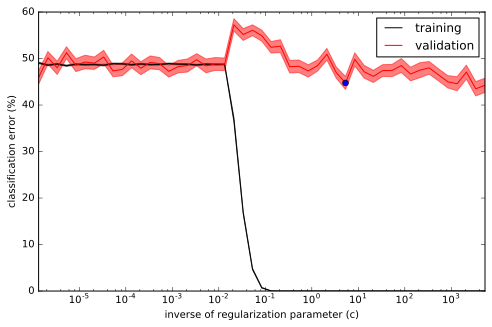

In [12]:
##%%%%%% plot coss-validation results
print 'Best regularization parameter = %.2f' %cbest
plt.figure('cross validation')

plt.fill_between(cvect, meanPerClassErrorTrain-semPerClassErrorTrain, meanPerClassErrorTrain+ semPerClassErrorTrain, alpha=0.5, edgecolor='k', facecolor='k')
plt.fill_between(cvect, meanPerClassErrorTest-semPerClassErrorTest, meanPerClassErrorTest+ semPerClassErrorTest, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(cvect, meanPerClassErrorTrain, 'k', label = 'training')
plt.plot(cvect, meanPerClassErrorTest, 'r', label = 'validation')
plt.plot(cvect[cvect==cbest], meanPerClassErrorTest[cvect==cbest], 'bo')
plt.xlim([cvect[1], cvect[-1]])
plt.xscale('log')
plt.xlabel('inverse of regularization parameter (c)')
plt.ylabel('classification error (%)')
plt.legend()

## Train SVM model using the best regularization parameter
    All data in X are used for training.
    linear_svm is the trained SVM model that includes weights (w) and intercept (b).

0.0


LinearSVC(C=5.3021625586571597, class_weight=None, dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l1', random_state=None,
     tol=0.0001, verbose=0)

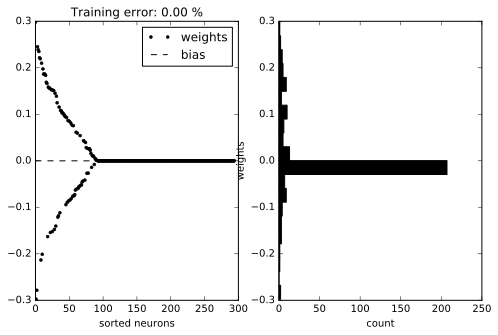

In [13]:
if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)

linear_svm.fit(X, Y)
    
w = np.squeeze(linear_svm.coef_);
b = linear_svm.intercept_;

plt.figure()
plt.subplot(1,2,1)
plt.plot(w[np.argsort(abs(w))[::-1]], 'k.', label = 'weights')
plt.plot(np.ones(len(w))*b, 'k--', label = 'bias')
plt.xlabel('sorted neurons')
plt.legend()
plt.title(('Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)))
print abs(((np.dot(X,w)+b)>0).astype('float')-Y.astype('float')).sum()/len(Y)*100 # this is the prediction formula
plt.subplot(1,2,2)
plt.hist(w, 20,orientation='horizontal', color = 'k')
plt.ylabel('weights')
plt.xlabel('count')

linear_svm

## Null distribution using shuffles
    Compute distritbutions of class loss for train and test datasets by fitting SVM for 100 times.
    Do this for both actual data and shuffled data (ie data in which Y is shuffled but X is not to serve as null distribution.)


In [14]:
numShuffles = 100
summary_data = [];
summary_shfl = [];
perClassErrorTrain_data = [];
perClassErrorTest_data = []
perClassErrorTrain_shfl = [];
perClassErrorTest_shfl = [];
w_data = []
b_data = []
w_shfl = []
b_shfl = []
permIxsList = [];
for i in range(numShuffles):
    permIxs = rng.permutation(numTrials);
    permIxsList.append(permIxs);
    if regType == 'l1':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
    elif regType == 'l2':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))
        
    perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
    perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
    w_data.append(np.squeeze(summary_data[i].model.coef_));
    b_data.append(summary_data[i].model.intercept_);
        
    perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
    perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
    w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
    b_shfl.append(summary_shfl[i].model.intercept_);

In [69]:
# extend the built in two tailed ttest function to one-tailed
def ttest2(a, b, **tailOption):
    import scipy.stats as stats
    h, p = stats.ttest_ind(a, b)
    d = np.mean(a)-np.mean(b)
    if tailOption.get('tail'):
        tail = tailOption.get('tail').lower()
        if tail == 'right':
            p = p/2.*(d>=0)+(1-p/2.)*(d<0)
        elif tail == 'left':
            p = (1-p/2.)*(d>=0)+p/2.*(d<0)
    return p


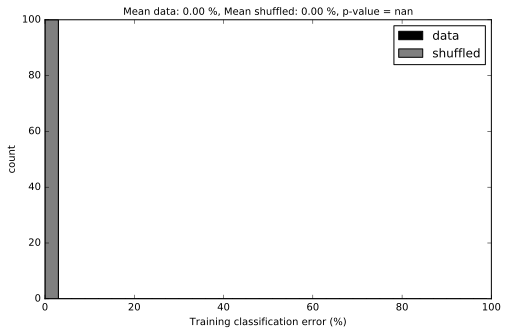

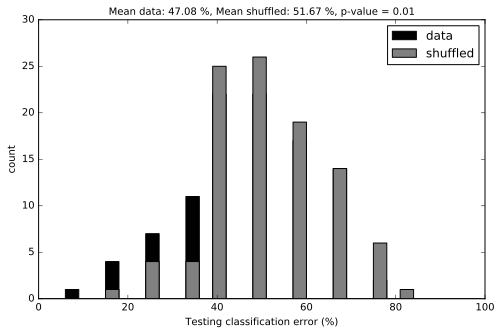

In [73]:
binEvery = 3; # bin width
pvalueTrain = ttest2(perClassErrorTrain_data, perClassErrorTrain_shfl, tail = 'left');
pvalueTest = ttest2(perClassErrorTest_data, perClassErrorTest_shfl, tail = 'left');

plt.figure()
# plt.subplot(2,1,1)
plt.hist(perClassErrorTrain_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTrain_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.xlabel('Training classification error (%)')
plt.ylabel('count')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%, p-value = %.2f' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl), pvalueTrain), fontsize = 10)
plt.legend()

plt.figure()
# plt.subplot(2,1,2)
plt.hist(perClassErrorTest_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTest_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.legend()
plt.xlabel('Testing classification error (%)')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%, p-value = %.2f' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl), pvalueTest), fontsize = 10)
plt.ylabel('count')

## Project traces onto SVM weights
    Stimulus-aligned and choice-aligned traces projected onto SVM fitted weights.
    More specifically, project traces of all trials onto normalized w (ie SVM weights computed from fitting model using X and Y of all trials).

In [ ]:
w_normalized = w/sci.linalg.norm(w);

# stim-aligned traces
XtN_w = np.dot(Xt_N, w_normalized);
Xt_w = np.reshape(XtN_w, (T,C), order='F');

# goTone-aligned 
XtgN_w = np.dot(Xtg_N, w_normalized);
Xtg_w = np.reshape(XtgN_w, (Tg,C), order='F');

# choice-aligned 
XtcN_w = np.dot(Xtc_N, w_normalized);
Xtc_w = np.reshape(XtcN_w, (Tc,C), order='F');

# reward-aligned 
XtrN_w = np.dot(Xtr_N, w_normalized);
Xtr_w = np.reshape(XtrN_w, (Tr,C), order='F');

# incommitResp-aligned 
XtpN_w = np.dot(Xtp_N, w_normalized);
Xtp_w = np.reshape(XtpN_w, (Tp,C), order='F');

## Plot projections and raw averages of neural population responses

In [ ]:
# window of training (ep)
win = (ep-eventI)*frameLength


# stim-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.mean(Xt_w[:, Y>0],  axis = 1)
tr1_se = np.std(Xt_w[:, Y>0],  axis = 1) / np.sqrt(numTrials);
tr0 = np.mean(Xt_w[:, Y<1],  axis = 1)
tr0_se = np.std(Xt_w[:, Y<1],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
mn = np.concatenate([tr1,tr0]).min()
mx = np.concatenate([tr1,tr0]).max()
plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Projections onto classifier weights')
plt.legend()

plt.subplot(1,2,2)
a1 = np.mean(Xt[:, :, Y>0],  axis=1) # frames x trials (average across neurons)
tr1 = np.mean(a1,  axis = 1)
tr1_se = np.std(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.mean(Xt[:, :, Y<1],  axis=1) # frames x trials (average across neurons)
tr0 = np.mean(a0,  axis = 1)
tr0_se = np.std(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
# plt.plot(time_aligned_stim, np.mean(Xt[:, :, Y<1],  axis = (1, 2)), 'r', label = 'high rate')
# plt.plot(time_aligned_stim, np.mean(Xt[:, :, Y>0],  axis = (1, 2)), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Population average')
plt.legend()



# goTone-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.mean(Xtg_w[:, Y>0],  axis = 1)
tr1_se = np.std(Xtg_w[:, Y>0],  axis = 1) / np.sqrt(numTrials);
tr0 = np.mean(Xtg_w[:, Y<1],  axis = 1)
tr0_se = np.std(Xtg_w[:, Y<1],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
# tr1=np.mean(Xtc_w[:, Y>0],  axis = 1)
# tr0=np.mean(Xtc_w[:, Y<1],  axis = 1)
# plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
# plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
plt.xlabel('time aligned to go tone (ms)')
plt.title('Projections onto classifier weights')
plt.legend()


plt.subplot(1,2,2)
a1 = np.mean(Xtg[:, :, Y>0],  axis=1) # frames x trials
tr1 = np.mean(a1,  axis = 1)
tr1_se = np.std(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.mean(Xtg[:, :, Y<1],  axis=1) # frames x trials
tr0 = np.mean(a0,  axis = 1)
tr0_se = np.std(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to go tone (ms)')
plt.title('Population average')
plt.legend()



# choice-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.mean(Xtc_w[:, Y>0],  axis = 1)
tr1_se = np.std(Xtc_w[:, Y>0],  axis = 1) / np.sqrt(numTrials);
tr0 = np.mean(Xtc_w[:, Y<1],  axis = 1)
tr0_se = np.std(Xtc_w[:, Y<1],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to 1st choice (ms)')
plt.title('Projections onto classifier weights')
plt.legend()


plt.subplot(1,2,2)
a1 = np.mean(Xtc[:, :, Y>0],  axis=1) # frames x trials
tr1 = np.mean(a1,  axis = 1)
tr1_se = np.std(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.mean(Xtc[:, :, Y<1],  axis=1) # frames x trials
tr0 = np.mean(a0,  axis = 1)
tr0_se = np.std(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to 1st choice (ms)')
plt.title('Population average')
plt.legend()




# reward-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.mean(Xtr_w[:, Y>0],  axis = 1)
tr1_se = np.std(Xtr_w[:, Y>0],  axis = 1) / np.sqrt(numTrials);
tr0 = np.mean(Xtr_w[:, Y<1],  axis = 1)
tr0_se = np.std(Xtr_w[:, Y<1],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to reward (ms)')
plt.title('Projections onto classifier weights')
plt.legend()


plt.subplot(1,2,2)
a1 = np.mean(Xtr[:, :, Y>0],  axis=1) # frames x trials
tr1 = np.mean(a1,  axis = 1)
tr1_se = np.std(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.mean(Xtr[:, :, Y<1],  axis=1) # frames x trials
tr0 = np.mean(a0,  axis = 1)
tr0_se = np.std(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to reward (ms)')
plt.title('Population average')
plt.legend()




# incommitResp-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.mean(Xtp_w[:, Y>0],  axis = 1)
tr1_se = np.std(Xtp_w[:, Y>0],  axis = 1) / np.sqrt(numTrials);
tr0 = np.mean(Xtp_w[:, Y<1],  axis = 1)
tr0_se = np.std(Xtp_w[:, Y<1],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to incorrResp (ms)')
plt.title('Projections onto classifier weights')
plt.legend()


plt.subplot(1,2,2)
a1 = np.mean(Xtp[:, :, Y>0],  axis=1) # frames x trials
tr1 = np.mean(a1,  axis = 1)
tr1_se = np.std(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.mean(Xtp[:, :, Y<1],  axis=1) # frames x trials
tr0 = np.mean(a0,  axis = 1)
tr0_se = np.std(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to incorrResp (ms)')
plt.title('Population average')
plt.legend()

## Classification accuracy at each time point

In [ ]:
# perClassCorr_t = [];
corrClass = np.ones((T, numTrials)) + np.nan # frames x trials
for t in range(T):
    trac = np.squeeze(Xt[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
    corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
    corrClass[t,:] = corrFract # frames x trials % fraction correct classification for all trials
#     perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

In [ ]:
a = np.mean(corrClass, axis=1)*100 
s = np.std(corrClass, axis=1)*100 /np.sqrt(numTrials);

plt.figure()
plt.fill_between(time_aligned_stim, a-s, a+s, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, a, 'r')
plt.xlabel('time since stimulus onset (ms)')
plt.ylabel('classification accuracy (%)')

## Save results


In [ ]:
svmName = os.path.join(os.path.dirname(pnevFileName), 'svmResults_'+os.path.basename(pnevFileName))
print(svmName)

scio.savemat(svmName, {'w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl})

# save normalized traces as well                       
# scio.savemat(svmName, {w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'X':X, 'Y':Y, 'Xt':Xt, 'Xtg':Xtg, 'Xtc':Xtc, 'Xtr':Xtr, 'Xtp':Xtp})
# 'linear_svm':linear_svm, 

# append : doesn't quite work
# if os.path.isfile(svmName): 
#     with open(svmName,'ab') as f:
#         sci.io.savemat(f, {'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl}) # append
# else:
